In [20]:
import sys
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import requests
import datetime
from backtesting import Backtest, Strategy
import bt
from typing import Callable
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

In [21]:
data = yf.download('AMZN', start='2017-12-01', end='2022-12-31')
print(data)

[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2017-12-01  58.602501  58.982498  57.599998  58.117500  58.117500   82142000
2017-12-04  58.692501  58.759998  56.400002  56.697498  56.697498  118638000
2017-12-05  56.412998  57.963501  56.237000  57.078499  57.078499   81596000
2017-12-06  56.899502  57.794498  56.804001  57.617500  57.617500   57066000
2017-12-07  57.829498  58.159500  57.549999  57.989498  57.989498   50232000
...               ...        ...        ...        ...        ...        ...
2022-12-23  83.250000  85.779999  82.930000  85.250000  85.250000   57433700
2022-12-27  84.970001  85.349998  83.000000  83.040001  83.040001   57284000
2022-12-28  82.800003  83.480003  81.690002  81.820000  81.820000   58228600
2022-12-29  82.870003  84.550003  82.550003  84.180000  84.180000   54995900
2022-12

Calculate Relative Strength Index (RSI) and Bollinger Bands indicators that will define conditions to enter a trade. Using typical for mean-reversion strategy period of 14 days. 

In [22]:
#Bollinger Bands loopback
ma_20 = 20

#Calculate Bollinger Bands 
data['ma_20'] = data['Adj Close'].rolling(ma_20).mean()
data['std'] = data['Adj Close'].rolling(ma_20).std()
data['upper_bollinger'] = data['ma_20'] + (2 * data['std'])
data['lower_bollinger'] = data['ma_20'] - (2 * data['std'])

#RSI loopback
period = 14


#Calculate RSI
def calculate_rsi(prices: pd.Series, loopback: Callable):
    
    price_delta = prices.diff()
    price_delta = price_delta[1:] 
    
    gain, loss = price_delta.clip(lower=0), price_delta.clip(upper=0).abs()
    
    loopback_gain = loopback(gain)
    loopback_loss = loopback(loss)
    
    rs = loopback_gain/loopback_loss
    rsi = 100 - (100/(rs+1))
    
    return rsi

rsi_ema = calculate_rsi(data['Adj Close'], lambda s: s.ewm(span=period).mean()) #exponential weighted moving average
rsi_sma = calculate_rsi(data['Adj Close'], lambda s: s.rolling(period).mean()) #simple moving average
rsi_rma = calculate_rsi(data['Adj Close'], lambda s: s.ewm(alpha=1 / period).mean()) #modified/running moving average
data['rsi'] = rsi_sma
print(data)

                 Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2017-12-01  58.602501  58.982498  57.599998  58.117500  58.117500   82142000   
2017-12-04  58.692501  58.759998  56.400002  56.697498  56.697498  118638000   
2017-12-05  56.412998  57.963501  56.237000  57.078499  57.078499   81596000   
2017-12-06  56.899502  57.794498  56.804001  57.617500  57.617500   57066000   
2017-12-07  57.829498  58.159500  57.549999  57.989498  57.989498   50232000   
...               ...        ...        ...        ...        ...        ...   
2022-12-23  83.250000  85.779999  82.930000  85.250000  85.250000   57433700   
2022-12-27  84.970001  85.349998  83.000000  83.040001  83.040001   57284000   
2022-12-28  82.800003  83.480003  81.690002  81.820000  81.820000   58228600   
2022-12-29  82.870003  84.550003  82.550003  84.180000  84.180000   54995900   
2022-12-30  83.120003  84.050003  82.470

Vizualize Bollinger Bands

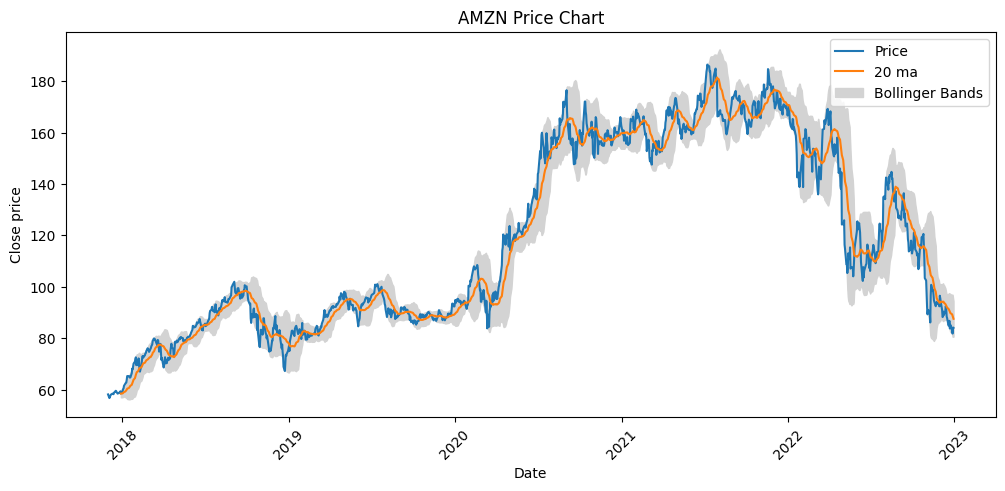

In [23]:
plt.figure(figsize=(12,5))

plt.plot(data.index, data['Adj Close'], label = 'Price')
plt.plot(data.index, data['ma_20'], label = '20 ma')
plt.fill_between(data.index, data['upper_bollinger'], data['lower_bollinger'], label = 'Bollinger Bands', color='lightgrey')
plt.title('AMZN Price Chart')
plt.xlabel('Date')
plt.ylabel('Close price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Vizualize RSI

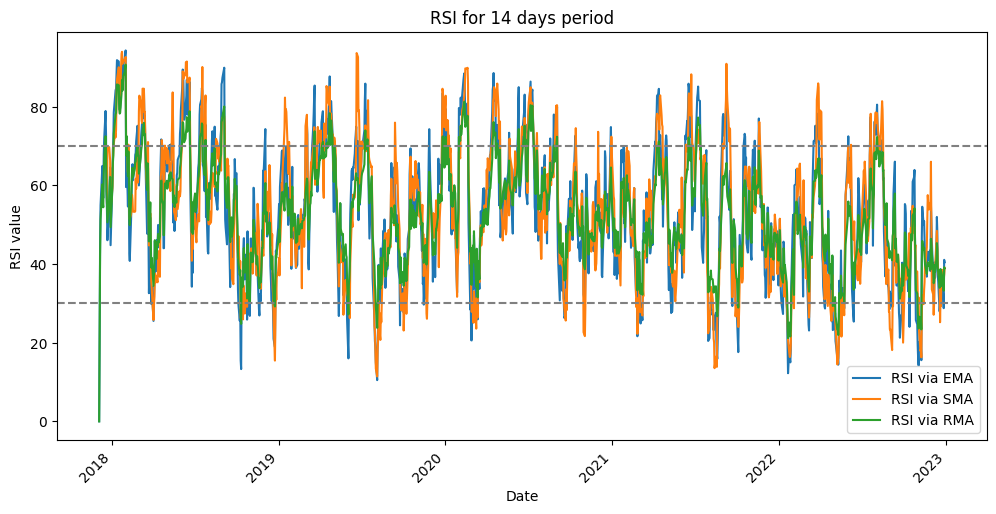

In [24]:
plt.figure(figsize=(12, 6))
rsi_ema.plot()
rsi_sma.plot()
rsi_rma.plot()
plt.axhline(30, c= (.5,.5,.5), ls='--')
plt.axhline(70, c= (.5,.5,.5), ls='--')
plt.title('RSI for 14 days period')
plt.xlabel('Date')
plt.ylabel('RSI value')
plt.xticks(rotation=45)
plt.legend(['RSI via EMA', 'RSI via SMA', 'RSI via RMA'])
plt.show()

Construct RSI-based and BB-based signals.

In [25]:
rsi_data = data[['Adj Close', 'rsi']]
bb_data = data[['Adj Close', 'lower_bollinger','upper_bollinger']]

def RSI_signal(data: pd.DataFrame):
    
    #short signal
    data['signal'] = np.where(data['rsi'] > 70, -1, np.nan)
    #buy signal
    data['signal'] = np.where(data['rsi'] < 30, 1, data['signal'])
    #zero signal
    data['signal'] = np.where((data['rsi'] > 30) & (data['rsi'] < 70), 0, data['signal'])
    data['signal'] = data['signal'].fillna(0)

    return data


def bb_signal(data: pd.DataFrame):
    
    #short signal
    data['signal'] = np.where(data['Adj Close'] > data['upper_bollinger'], -1, np.nan)
    #buy signal
    data['signal'] = np.where(data['Adj Close'] < data['lower_bollinger'], 1, data['signal'])
    #zero signal
    data['signal'] = np.where((data['Adj Close'] < data['upper_bollinger']) & (data['Adj Close'] > data['lower_bollinger']), 0, data['signal'])
    data['signal'] = data['signal'].fillna(0)

    return data


rsi_signal = RSI_signal(rsi_data)
bb_signal = bb_signal(bb_data)

Backtest 1: Backtest both strategies using RSI-based and BB-based signals and vizualize results.

RSI strategy returns: 0.5987872608437943
Bollinger Bands strategy returns: -0.2365917829861246


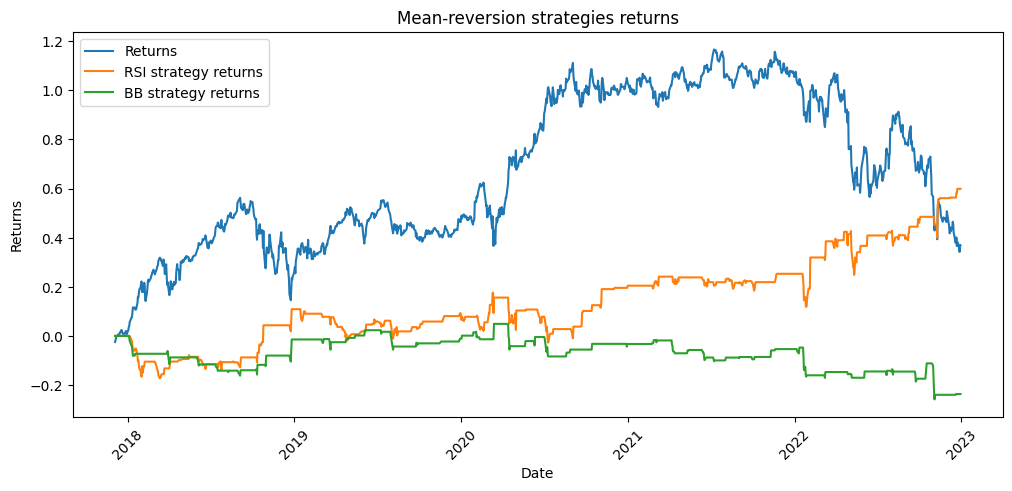

In [26]:
def strategy_bactesting(data: pd.DataFrame):
    
    #calculate position and strategy returns, tarding the next day after signal
    data['log_returns'] = np.log(data['Adj Close']).diff()
    data['position'] = data['signal'].ffill().fillna(0) 
    data['strategy_returns'] = data['position'].shift(1) * data['log_returns']  
    
    return data
    
rsi_strategy = strategy_bactesting(rsi_signal)
bb_strategy = strategy_bactesting(bb_signal)

print("RSI strategy returns:", rsi_strategy['strategy_returns'].cumsum()[-1])
print("Bollinger Bands strategy returns:", bb_strategy['strategy_returns'].cumsum()[-1])

plt.figure(figsize=(12,5))

plt.plot(rsi_strategy.index, rsi_strategy['log_returns'].cumsum(), label = 'Returns')
plt.plot(rsi_strategy.index, rsi_strategy['strategy_returns'].cumsum(), label = 'RSI strategy returns')
plt.plot(bb_strategy.index, bb_strategy['strategy_returns'].cumsum(), label = 'BB strategy returns')
plt.title('Mean-reversion strategies returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Backtest 2: using external 'backtesting' module.

C:\Users\piotr\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\future\utils\__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
C:\Users\piotr\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\future\utils\__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
C:\Users\piotr\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\future\utils\__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
C:\Users\piotr\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\future\utils\__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)


Stat                 Mean Reversion - RSI    Mean Reversion - Bollinger Bands
-------------------  ----------------------  ----------------------------------
Start                2017-11-30              2017-11-30
End                  2022-12-30              2022-12-30
Risk-free rate       0.00%                   0.00%

Total Return         70.69%                  -22.91%
Daily Sharpe         0.64                    -0.39
Daily Sortino        1.12                    -0.55
CAGR                 11.10%                  -4.99%
Max Drawdown         -20.22%                 -27.72%
Calmar Ratio         0.55                    -0.18

MTD                  3.88%                   0.32%
3m                   14.92%                  -6.05%
6m                   20.47%                  -8.89%
YTD                  40.16%                  -16.88%
1Y                   40.16%                  -16.88%
3Y (ann.)            16.69%                  -7.80%
5Y (ann.)            11.31%                  -5.08%
1

<Axes: title={'center': 'Backtest result: RSI vs. Bollinger Bands'}>

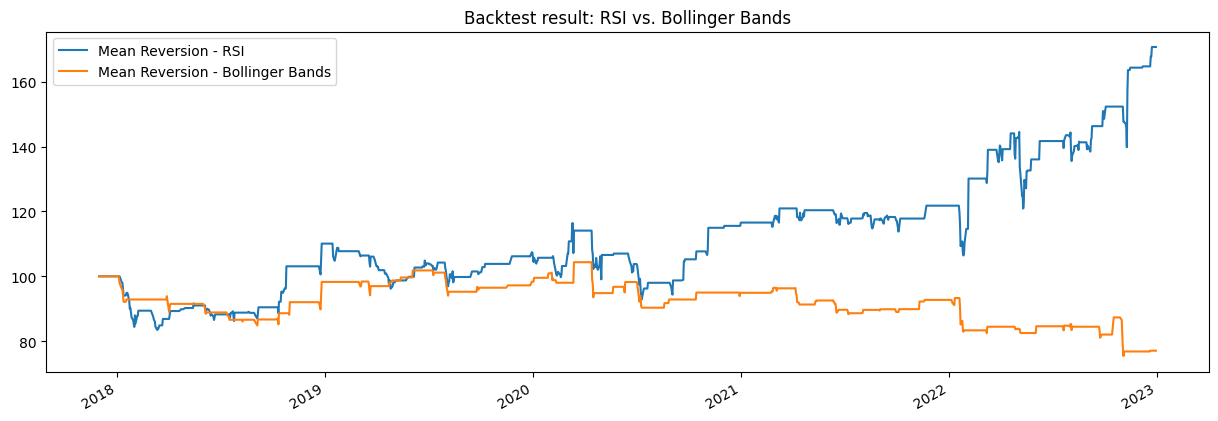

In [45]:
def strategy_bactesting_bt(data: pd.DataFrame, signal_name: str, strategy_name: str):
    signal = data[signal_name].astype(float).to_frame().copy()
    signal.rename(columns = {signal_name:'Adj Close'}, inplace = True)
    strategy = bt.Strategy(strategy_name, [bt.algos.WeighTarget(signal), bt.algos.Rebalance()])
    backtest = bt.Backtest(strategy, data)
    
    return backtest

data_bt = data 
data_bt['rsi_signal'] = rsi_signal['signal']
data_bt['bb_signal'] = bb_signal['signal']
backtest_rsi_bt = strategy_bactesting_bt(data_bt, 'rsi_signal', "Mean Reversion - RSI")
backtest_bb_bt = strategy_bactesting_bt(data_bt, 'bb_signal', "Mean Reversion - Bollinger Bands")

result = bt.run(backtest_rsi_bt, backtest_bb_bt)

#Plot the backtest result
result.display()
result.plot(title='Backtest result: RSI vs. Bollinger Bands')

Test 2:

In [56]:
def backtest_dataframe(df):
    position = 0
    net_profit = 0
    percentage_change = []
    df['buy_date'] = ''
    df['sell_date'] = ''

    for i in df.index:
        close = df["Adj Close"][i]
        date = i

        # Buy action
        if df["signal"][i] == 1:
            if(position == 0):
                buy_price = close
                position = 1
                df.at[i, 'buy_date'] = date
                print(f"Buying at {str(buy_price)} on {str(date)}")

        # Sell action
        elif (df["signal"][i] == -1):
            if(position == 1):
                sell_price = close
                bought = 0
                position = 0
                df.at[i, 'sell_date'] = date
                print(f"Selling at {str(sell_price)} on {str(date)}")

                # Get percentage change of trade
                pc = (sell_price/buy_price-1)*100
                percentage_change.append(pc)
                net_profit += (sell_price - buy_price)

    # Calculate trade statistics
    gains = 0
    ng = 0
    losses = 0
    nl = 0
    totalR = 1

    for i in percentage_change:
        if(i > 0):
            gains += i
            ng += 1
        else:
            losses += i
            nl += 1
        totalR = totalR * ((i/100)+1)

    totalR = round((totalR-1)*100, 2)

    if(ng > 0):
        avgGain = round(gains/ng, 2)
        maxR = round(max(percentage_change), 2)
    else:
        avgGain = 0
        maxR = "undefined"

    if(nl > 0):
        avgLoss = round(losses/nl, 2)
        maxL = round(min(percentage_change), 2)
    else:
        avgLoss = 0
        maxL = "undefined"

    if(ng > 0 or nl > 0):
        win_rate = round((ng/(ng+nl))*100, 2)
    else:
        win_rate = 0

    print()
    print('Evaluation Metrics:')
    print('-----------------------------------')
    print(f"Number of Trades: {ng+nl}")
    print(f"Number of Gains: {ng}")
    print(f"Number of Losses: {nl}")
    print(f"Total Returns: {totalR}%")
    print(f"Win Rate: {win_rate}%")
    print(f"Average Gain: {avgGain}%")
    print(f"Average Loss: {avgLoss}%")
    print(f"Max Return: {maxR}%")
    print(f"Max Loss: {maxL}%")
    print()

backtest_dataframe(rsi_signal)
backtest_dataframe(bb_signal)

Buying at 68.59950256347656 on 2018-04-02 00:00:00
Selling at 76.37449645996094 on 2018-04-20 00:00:00
Buying at 87.76249694824219 on 2018-10-10 00:00:00
Selling at 80.8604965209961 on 2019-01-14 00:00:00
Buying at 90.77400207519531 on 2019-05-23 00:00:00
Selling at 95.90950012207031 on 2019-06-20 00:00:00
Buying at 94.92649841308594 on 2019-07-30 00:00:00
Selling at 91.96700286865234 on 2019-09-13 00:00:00
Buying at 86.99199676513672 on 2019-09-26 00:00:00
Selling at 93.4384994506836 on 2019-12-26 00:00:00
Buying at 94.1875 on 2020-02-28 00:00:00
Selling at 108.44349670410156 on 2020-04-13 00:00:00
Buying at 147.74549865722656 on 2020-09-18 00:00:00
Selling at 172.18150329589844 on 2020-10-13 00:00:00
Buying at 151.8074951171875 on 2020-10-30 00:00:00
Selling at 161.00399780273438 on 2020-12-01 00:00:00
Buying at 159.72500610351562 on 2021-02-23 00:00:00
Selling at 164.96499633789062 on 2021-04-08 00:00:00
Buying at 166.37950134277344 on 2021-07-30 00:00:00
Selling at 173.539505004882

In [16]:
#buy signal
data['signal'] = np.where((data['rsi'] < 30) & (data['Adj Close'] < data['lower_bollinger']), 1, 0)

#sell signal
data['signal'] = np.where((data['rsi'] > 70) & (data['Adj Close'] > data['upper_bollinger']), -1, data['signal'])

signal = data['signal'].astype(float).to_frame().copy()

signal.rename(columns = {'signal':'Price'}, inplace = True)
signal

,Price
Date,
2017-12-01,0.0
2017-12-04,0.0
2017-12-05,0.0
2017-12-06,0.0
2017-12-07,0.0
...,...
2022-12-23,0.0
2022-12-27,0.0
2022-12-28,0.0


Testing (bt)

In [17]:
#signal.rename(columns = {0:'AMZN'}, inplace = True)
bt_strategy = bt.Strategy('MeanReversion', [bt.algos.WeighTarget(signal), bt.algos.Rebalance()])
bt_backtest = bt.Backtest(bt_strategy, data)
bt_result = bt.run(bt_backtest)
# Plot the backtest result
bt_result.plot(title='Backtest result')
bt_result.display()
signal

C:\Users\piotr\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\future\utils\__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)


Exception: Cannot allocate capital to Price because price is 0 as of 2018-01-05 00:00:00

Signal construction (personal)

                 Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2017-12-01  58.602501  58.982498  57.599998  58.117500  58.117500   82142000   
2017-12-04  58.692501  58.759998  56.400002  56.697498  56.697498  118638000   
2017-12-05  56.412998  57.963501  56.237000  57.078499  57.078499   81596000   
2017-12-06  56.899502  57.794498  56.804001  57.617500  57.617500   57066000   
2017-12-07  57.829498  58.159500  57.549999  57.989498  57.989498   50232000   
...               ...        ...        ...        ...        ...        ...   
2022-12-23  83.250000  85.779999  82.930000  85.250000  85.250000   57433700   
2022-12-27  84.970001  85.349998  83.000000  83.040001  83.040001   57284000   
2022-12-28  82.800003  83.480003  81.690002  81.820000  81.820000   58228600   
2022-12-29  82.870003  84.550003  82.550003  84.180000  84.180000   54995900   
2022-12-30  83.120003  84.050003  82.470

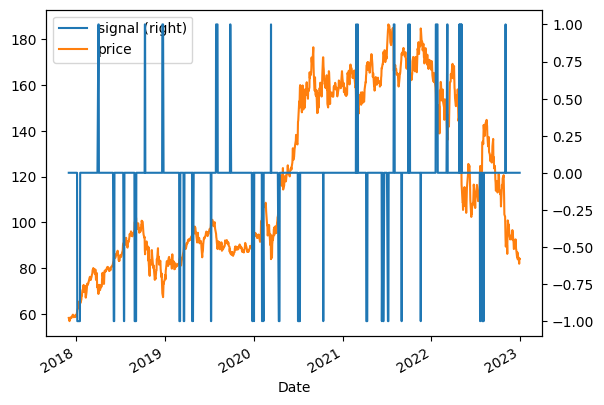

In [49]:
df['rsi'] = rsi_sma
#buy signal
df['signal'] = np.where(
    (df['rsi'] < 30) &
    (df['Adj Close'] < df['lower_bollinger']), 1, 0)

#sell signal
df['signal'] = np.where(
    (df['rsi'] > 70) & 
    (df['Adj Close'] > df['upper_bollinger']), -1, df['signal'])

#prepare data for backtesting
test_df = bt.merge(df['signal'], df['Adj Close'])
test_df.columns = ['signal', 'price']
test_df.plot(secondary_y =['signal'])

print(df[df['signal'].notna()])

Testing (personal)

In [40]:
rsi_strategy_bt2 = rsi_strategy
def backtest_dataframe(df):
    position = 0
    net_profit = 0
    percentage_change = []
    df['buy_date'] = ''
    df['sell_date'] = ''

    for i in df.index:
        close = df["Adj Close"][i]
        date = i

        # Buy action
        if df["signal"][i] == 1:
            if(position == 0):
                buy_price = close
                position = 1
                df.at[i, 'buy_date'] = date
                print(f"Buying at {str(buy_price)} on {str(date)}")

        # Sell action
        elif (df["signal"][i] == -1):
            if(position == 1):
                sell_price = close
                bought = 0
                position = 0
                df.at[i, 'sell_date'] = date
                print(f"Selling at {str(sell_price)} on {str(date)}")

                # Get percentage change of trade
                pc = (sell_price/buy_price-1)*100
                percentage_change.append(pc)
                net_profit += (sell_price - buy_price)

    # Calculate trade statistics
    gains = 0
    ng = 0
    losses = 0
    nl = 0
    totalR = 1

    for i in percentage_change:
        if(i > 0):
            gains += i
            ng += 1
        else:
            losses += i
            nl += 1
        totalR = totalR * ((i/100)+1)

    totalR = round((totalR-1)*100, 2)

    if(ng > 0):
        avgGain = round(gains/ng, 2)
        maxR = round(max(percentage_change), 2)
    else:
        avgGain = 0
        maxR = "undefined"

    if(nl > 0):
        avgLoss = round(losses/nl, 2)
        maxL = round(min(percentage_change), 2)
    else:
        avgLoss = 0
        maxL = "undefined"

    if(ng > 0 or nl > 0):
        win_rate = round((ng/(ng+nl))*100, 2)
    else:
        win_rate = 0

    print()
    print('Evaluation Metrics:')
    print('-----------------------------------')
    print(f"Number of Trades: {ng+nl}")
    print(f"Number of Gains: {ng}")
    print(f"Number of Losses: {nl}")
    print(f"Total Returns: {totalR}%")
    print(f"Win Rate: {win_rate}%")
    print(f"Average Gain: {avgGain}%")
    print(f"Average Loss: {avgLoss}%")
    print(f"Max Return: {maxR}%")
    print(f"Max Loss: {maxL}%")
    print()

    
backtest_dataframe(rsi_signal)

Buying at 68.59950256347656 on 2018-04-02 00:00:00
Selling at 76.37449645996094 on 2018-04-20 00:00:00
Buying at 87.76249694824219 on 2018-10-10 00:00:00
Selling at 80.8604965209961 on 2019-01-14 00:00:00
Buying at 90.77400207519531 on 2019-05-23 00:00:00
Selling at 95.90950012207031 on 2019-06-20 00:00:00
Buying at 94.92649841308594 on 2019-07-30 00:00:00
Selling at 91.96700286865234 on 2019-09-13 00:00:00
Buying at 86.99199676513672 on 2019-09-26 00:00:00
Selling at 93.4384994506836 on 2019-12-26 00:00:00
Buying at 94.1875 on 2020-02-28 00:00:00
Selling at 108.44349670410156 on 2020-04-13 00:00:00
Buying at 147.74549865722656 on 2020-09-18 00:00:00
Selling at 172.18150329589844 on 2020-10-13 00:00:00
Buying at 151.8074951171875 on 2020-10-30 00:00:00
Selling at 161.00399780273438 on 2020-12-01 00:00:00
Buying at 159.72500610351562 on 2021-02-23 00:00:00
Selling at 164.96499633789062 on 2021-04-08 00:00:00
Buying at 166.37950134277344 on 2021-07-30 00:00:00
Selling at 173.539505004882

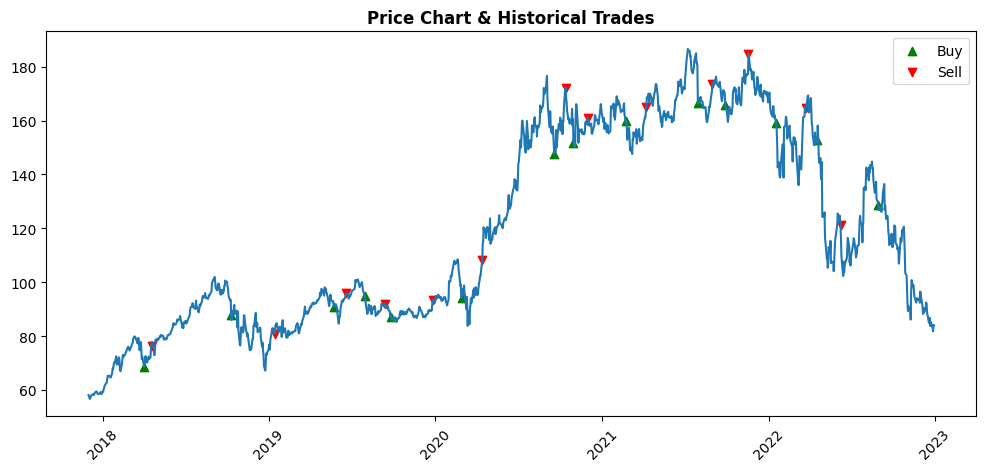

In [42]:
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)

plt.plot(rsi_signal.index, rsi_signal['Adj Close'])
plt.scatter(rsi_signal[(rsi_signal['signal'] == 1)]['buy_date'], rsi_signal[(rsi_signal['signal'] == 1)]['Adj Close'], label = 'Buy', marker='^', c='g')
plt.scatter(rsi_signal[(rsi_signal['signal'] == -1)]['sell_date'], rsi_signal[(rsi_signal['signal'] == -1)]['Adj Close'], label = 'Sell', marker='v', c='r')

plt.title('Price Chart & Historical Trades', fontweight="bold")
plt.legend()
plt.show()